In [1]:
import time
import pickle
import math
import pandas as pd
import numpy as np
import scipy.sparse
from sklearn import preprocessing

In [2]:
SUBMISSION = False
SUBMISSION_FILENAME = 'submission.csv'
TEST_FILENAME = 'test.csv'

In [3]:
target_playlists = pd.read_csv('../datasets/target_playlists.csv', sep='\t')
target_tracks = pd.read_csv('../datasets/target_tracks.csv', sep='\t')
tracks_final = pd.read_csv('../datasets/tracks_final.csv', sep='\t')
playlists_final = pd.read_csv('../datasets/playlists_final.csv', sep='\t')
train_final = pd.read_csv('../datasets/train_final.csv', sep='\t')

print('Successfully read data')

Successfully read data


In [4]:
def check_matrix(X, format='csc', dtype=np.float32):
    if format == 'csc' and not isinstance(X, scipy.sparse.csc_matrix):
        return X.tocsc().astype(dtype)
    elif format == 'csr' and not isinstance(X, scipy.sparse.csr_matrix):
        return X.tocsr().astype(dtype)
    elif format == 'coo' and not isinstance(X, scipy.sparse.coo_matrix):
        return X.tocoo().astype(dtype)
    elif format == 'dok' and not isinstance(X, scipy.sparse.dok_matrix):
        return X.todok().astype(dtype)
    elif format == 'bsr' and not isinstance(X, scipy.sparse.bsr_matrix):
        return X.tobsr().astype(dtype)
    elif format == 'dia' and not isinstance(X, scipy.sparse.dia_matrix):
        return X.todia().astype(dtype)
    elif format == 'lil' and not isinstance(X, scipy.sparse.lil_matrix):
        return X.tolil().astype(dtype)
    else:
        return X.astype(dtype)

In [5]:
def is_relevant(recommendation_item, validation_set):
    validation_item = validation_set.loc[validation_set['playlist_id'] == recommendation_item['playlist_id']]
    recommendation_item['recommendation'] = pd.Series(recommendation_item['recommendation'])\
                                                .isin(list(validation_item['track_id']))
    return recommendation_item


def precision(recommended_items_relevance):
    precision_scores = recommended_items_relevance.sum(axis=1) / recommended_items_relevance.shape[1]
    return precision_scores.mean()


def mAP(recommended_items_relevance):
    p_at_k = recommended_items_relevance.cumsum(axis=1) / (1 + np.arange(recommended_items_relevance.shape[1]))
    recommended_items_mAP = p_at_k.sum(axis=1) / recommended_items_relevance.shape[1]
    return recommended_items_mAP.mean()


def evaluate_recommendations(recommended_items, validation_set):
    items_relevance = recommended_items.apply(lambda recommendation_item: is_relevant(recommendation_item, validation_set), axis=1)
    recommended_items_relevance = pd.DataFrame(list(items_relevance['recommendation']), index=items_relevance['recommendation'].index)
    precision_score = precision(recommended_items_relevance)
    mAP_score = mAP(recommended_items_relevance)
    return precision_score, mAP_score

def evaluate(recommended_items, validation_set):
    print('Evaluating...')
    begin = time.time()
    precision_score, mAP_score = evaluate_recommendations(recommended_items, validation_set)
    print('Precision: {0:.{digits}f}, mAP: {1:.{digits}f}, took {2:.{digits}f}s'
          .format(precision_score, mAP_score, time.time() - begin, digits=5))

In [6]:
def str_tags_to_list(str_tags):
    if str_tags == '[]':
        return []
    return list(map(int, str_tags.replace('[', '').replace(']', '').replace(' ', '').split(',')))


def str_album_to_int(album):
    if album == '[]' or album == '[None]':
        return -1
    return int(album.replace('[', '').replace(']', ''))

def round_ceil(x, name):
    x[name] = int(math.ceil(x[name]))
    return x

In [7]:
def get_playlist_titles(playlist_final):
    playlist_tags_list = str_tags_to_list(playlist_final['title'])
    return [[playlist_final['playlist_id'], playlist_tag] for playlist_tag in playlist_tags_list]

playlist_titles = pd.concat([pd.DataFrame(data=get_playlist_titles(playlist_final), columns=['playlist_id', 'title']) for index, playlist_final in playlists_final.iterrows()])
print('playlist_titles {}'.format(playlist_titles.shape))
print(playlist_titles.head(6))

playlist_titles (108382, 2)
  playlist_id  title
0      644838  12727
0     3120683    183
0     4278112  12389
1     4278112  18698
2     4278112  18925
3     4278112  11695


In [8]:
playlist_owner = pd.DataFrame()
playlist_owner['playlist_id'] = playlists_final['playlist_id']
playlist_owner['owner'] = playlists_final['owner']
print('playlist_owner {}'.format(playlist_owner.shape))
print(playlist_owner.head(6))

playlist_owner (57561, 2)
   playlist_id  owner
0       644838  41504
1      7577564  41504
2      3120683  44542
3      4278112  44542
4      8656823  44542
5     10961458  44542


In [9]:
print('Data info:')
print('Playlist with at least one title count: {}'.format(playlist_titles['playlist_id'].nunique()))
print('Unique title count: {}\n'.format(playlist_titles['title'].nunique()))

print('Playlist with owner count: {}'.format(playlist_owner['playlist_id'].nunique()))
print('Unique owner count: {}\n'.format(playlist_owner['owner'].nunique()))

print('Unique tracks count: {}'.format(tracks_final['track_id'].nunique()))
print('Unique playlist count: {}'.format(playlists_final['playlist_id'].nunique()))
print('Target tracks count: {}'.format(target_tracks['track_id'].nunique()))
print('Target playlists count: {}'.format(target_playlists['playlist_id'].nunique()))

Data info:
Playlist with at least one title count: 52384
Unique title count: 21064

Playlist with owner count: 57561
Unique owner count: 15264

Unique tracks count: 100000
Unique playlist count: 57561
Target tracks count: 32195
Target playlists count: 10000


In [10]:
playlist_id_le = preprocessing.LabelEncoder()
playlist_id_le.fit(list(playlists_final['playlist_id']))
print('playlist_id_le classes: {}'.format(len(playlist_id_le.classes_)))

track_id_le = preprocessing.LabelEncoder()
track_id_le.fit(list(tracks_final['track_id']))
print('track_id_le classes: {}'.format(len(track_id_le.classes_)))

title_le = preprocessing.LabelEncoder()
title_le.fit(list(playlist_titles['title']))
print('title_le classes: {}'.format(len(title_le.classes_)))

owner_le = preprocessing.LabelEncoder()
owner_le.fit(list(playlist_owner['owner']))
print('owner_le classes: {}'.format(len(owner_le.classes_)))

playlist_id_le classes: 57561
track_id_le classes: 100000
title_le classes: 21064
owner_le classes: 15264


In [11]:
unique_tracks_count = tracks_final['track_id'].nunique()

playlist_titles['transformed_playlist_id'] = playlist_id_le.transform(list(playlist_titles['playlist_id']))
playlist_titles['transformed_title_id'] = list(map(lambda x: x + unique_tracks_count,\
                                                   title_le.transform(list(playlist_titles['title']))))

playlist_owner['transformed_playlist_id'] = playlist_id_le.transform(list(playlist_owner['playlist_id']))
playlist_owner['transformed_owner'] = list(map(lambda x: x + unique_tracks_count + len(title_le.classes_),\
                                                   owner_le.transform(list(playlist_owner['owner']))))

print('playlist_titles')
print(playlist_titles.head(4))

print('playlist_owner')
print(playlist_owner.head(4))

playlist_titles
  playlist_id  title  transformed_playlist_id  transformed_title_id
0      644838  12727                     2514                112727
0     3120683    183                     7829                100183
0     4278112  12389                    14708                112389
1     4278112  18698                    14708                118698
playlist_owner
   playlist_id  owner  transformed_playlist_id  transformed_owner
0       644838  41504                     2514             132679
1      7577564  41504                    35844             132679
2      3120683  44542                     7829             135702
3      4278112  44542                    14708             135702


In [12]:
# Playlist and tracks that belong to them
target_playlists_and_tracks = pd.merge(target_playlists, train_final, on='playlist_id')
print('target_playlists_and_tracks {}'.format(target_playlists_and_tracks.shape))
print(target_playlists_and_tracks.head(10))

target_playlists_and_tracks (362661, 2)
   playlist_id  track_id
0     10024884   2879006
1     10024884   1532328
2     10024884   3027673
3     10024884   3236144
4     10024884   1563134
5     10024884    435345
6     10024884    353291
7     10024884    247331
8     10024884    161455
9     10024884   3338954


In [13]:
def split_training_data(train_final, target_playlists_and_tracks, random_state):
    validation_set = target_playlists_and_tracks.groupby(['playlist_id'])\
                        .apply(lambda x: x.sample(n=3, random_state=random_state))\
                        .reset_index(drop=True)
    df_concat = pd.concat([train_final, validation_set])
    training_set = df_concat.drop_duplicates(keep=False)
    return training_set, validation_set

# Split dataset - from all target playlists remove randomly 3 tracks
training_set, validation_set = split_training_data(train_final, target_playlists_and_tracks, random_state=0)
test_target_tracks = validation_set['track_id'].drop_duplicates(keep='first').to_frame()
test_target_tracks['transformed_track_id'] = track_id_le.transform(list(test_target_tracks['track_id']))
target_tracks['transformed_track_id'] = track_id_le.transform(list(target_tracks['track_id']))

training_set['transformed_track_id'] = track_id_le.transform(list(training_set['track_id']))
training_set['transformed_playlist_id'] = playlist_id_le.transform(list(training_set['playlist_id']))
target_playlists['transformed_playlist_id'] = playlist_id_le.transform(list(target_playlists['playlist_id']))

print('training_set: {}'.format(training_set.shape))
print(training_set.head(5))
print('validation_set: {}'.format(validation_set.shape))
print(validation_set.head(5))
print('test_target_tracks: {}'.format(test_target_tracks.shape))
print(test_target_tracks.head(5))

training_set: (1010522, 4)
   playlist_id  track_id  transformed_track_id  transformed_playlist_id
0      3271849   2801526                 71058                     8890
1      5616275    727878                 19741                    22426
2     11267488   2805283                 71298                    54743
3     10103900   1515105                 36851                    46970
4      3836898   2945623                 76310                    11967
validation_set: (30000, 2)
   playlist_id  track_id
0         7614   2141817
1         7614   3833025
2         7614   3711434
3         7692   2053595
4         7692   2172361
test_target_tracks: (21958, 2)
   track_id  transformed_track_id
0   2141817                 53522
1   3833025                 97760
2   3711434                 94876
3   2053595                 51310
4   2172361                 54282


In [14]:
urm_ones = np.ones(training_set.shape[0])
print('urm_ones shape: {}, vector: {}'.format(urm_ones.shape, urm_ones))

URM = scipy.sparse.coo_matrix((urm_ones, (list(training_set['transformed_playlist_id']),
                                          list(training_set['transformed_track_id']))))
print(URM.shape)

urm_ones shape: (1010522,), vector: [ 1.  1.  1. ...,  1.  1.  1.]
(57561, 100000)


In [15]:
urm_with_params_ones = np.ones(training_set.shape[0] + playlist_titles.shape[0] + playlist_owner.shape[0])
print('urm_with_params_ones shape: {}, vector: {}'.format(urm_with_params_ones.shape, urm_with_params_ones))

URM_with_params = scipy.sparse.coo_matrix((urm_with_params_ones, (list(training_set['transformed_playlist_id']) + list(playlist_titles['transformed_playlist_id']) + list(playlist_owner['transformed_playlist_id']),
                                                                  list(training_set['transformed_track_id']) + list(playlist_titles['transformed_title_id']) + list(playlist_owner['transformed_owner']))))
URM_with_params = URM_with_params.tocsr()

print(URM_with_params.shape)
tracks_per_playlist = (URM_with_params > 0).sum(axis=1)
playlist_per_track = (URM_with_params > 0).sum(axis=0)

print('tracks_per_playlist.shape {}'.format(tracks_per_playlist.shape))
print('playlist_per_track.shape {}'.format(playlist_per_track.shape))

urm_with_params_ones shape: (1176465,), vector: [ 1.  1.  1. ...,  1.  1.  1.]
(57561, 136328)
tracks_per_playlist.shape (57561, 1)
playlist_per_track.shape (1, 136328)


In [16]:
num_tot_playlist = URM_with_params.shape[0]
IDF = np.array(np.log(num_tot_playlist / (playlist_per_track + 1)))[0]
URM_with_params_idf = URM_with_params.copy()
# compute the number of non-zeros in each col
# NOTE: this works only if X is instance of sparse.csc_matrix
col_nnz = np.diff(check_matrix(URM_with_params_idf, 'csc').indptr)
print(col_nnz.shape)
print(URM_with_params_idf.shape)
print(IDF.shape)
# then normalize the values in each col
URM_with_params_idf.data *= np.repeat(IDF, col_nnz)

(136328,)
(57561, 136328)
(136328,)


In [17]:
tracks_per_playlist = np.array(tracks_per_playlist).squeeze()
playlist_per_track = np.array(playlist_per_track).squeeze()

print(tracks_per_playlist.shape)
print(playlist_per_track.shape)

tracks_per_playlist = np.sort(tracks_per_playlist)
playlist_per_track = np.sort(playlist_per_track)

(57561,)
(136328,)


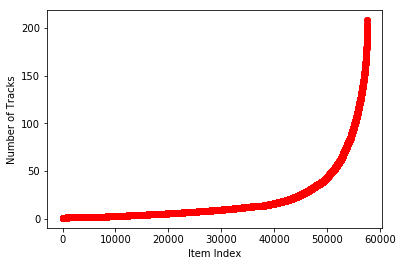

In [18]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(tracks_per_playlist, 'ro')
pyplot.ylabel('Number of Tracks')
pyplot.xlabel('Item Index')
pyplot.show()

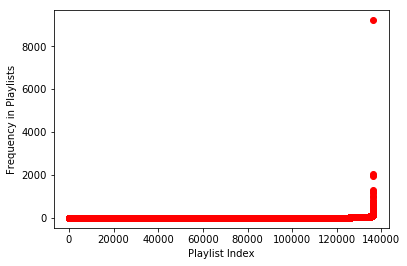

In [19]:
pyplot.plot(playlist_per_track, 'ro')
pyplot.ylabel('Frequency in Playlists')
pyplot.xlabel('Playlist Index')
pyplot.show()

In [20]:
class ISimilarity(object):
    """Abstract interface for the similarity metrics"""

    def __init__(self, shrinkage=10):
        self.shrinkage = shrinkage

    def compute(self, X):
        pass


class Cosine(ISimilarity):
    def compute(self, X):
        # convert to csc matrix for faster column-wise operations
        X = check_matrix(X, 'csc', dtype=np.float32)

        # 1) normalize the columns in X
        # compute the column-wise norm
        # NOTE: this is slightly inefficient. We must copy X to compute the column norms.
        # A faster solution is to  normalize the matrix inplace with a Cython function.
        Xsq = X.copy()
        Xsq.data **= 2
        norm = np.sqrt(Xsq.sum(axis=0))
        norm = np.asarray(norm).ravel()
        norm += 1e-6
        # compute the number of non-zeros in each column
        # NOTE: this works only if X is instance of sparse.csc_matrix
        
        col_nnz = np.diff(X.indptr)
        # then normalize the values in each column
        X.data /= np.repeat(norm, col_nnz)
        print("Normalized")

        # 2) compute the cosine similarity using the dot-product
        print("Computing distance")
        dist = X * X.T
        print("Computed")

        # and apply the shrinkage
        if self.shrinkage > 0:
            dist = self.apply_shrinkage(X, dist)
            print("Applied shrinkage")    
        
        return dist

    def apply_shrinkage(self, X, dist):
        # create an "indicator" version of X (i.e. replace values in X with ones)
        X_ind = X.copy()
        X_ind.data = np.ones_like(X_ind.data)
        # compute the co-rated counts
        co_counts = X_ind * X_ind.T
        # remove the diagonal
#         co_counts = co_counts - scipy.sparse.dia_matrix((co_counts.diagonal()[scipy.newaxis, :], [0]), shape=co_counts.shape)
        # compute the shrinkage factor as co_counts_ij / (co_counts_ij + shrinkage)
        # then multiply dist with it
        co_counts_shrink = co_counts.copy()
        co_counts_shrink.data += self.shrinkage
        co_counts.data /= co_counts_shrink.data
        dist.data *= co_counts.data
        return dist

In [21]:
distance = Cosine(shrinkage=0)
# playlist_similarity = distance.compute(URM_with_params_idf)
playlist_similarity = distance.compute(URM_with_params)

Normalized
Computing distance
Computed


In [22]:
class UserBasedRecommender:
    def __init__(self, k, to_predict=3):
        self.k = k
        self.to_predict = to_predict
    
    def fit(self, training_set, target_tracks, URM, playlist_similarity):
        self.training_set = training_set
        self.playlist_similarity = playlist_similarity
        self.URM = URM
        self.URM_csr = URM.tocsr()
    
        self.target_tracks_mask = np.zeros(URM.shape[1])
        for value in list(target_tracks['transformed_track_id']):
            self.target_tracks_mask[value] = 1
    
    def recommend(self, target_playlists):
        def make_recommendation(playlist):
            tracks_on_playlist = self.training_set.loc[self.training_set['playlist_id'] == playlist['playlist_id']]
            transformed_tracks_on_playlist = track_id_le.transform(list(tracks_on_playlist['track_id']))
            tracks_on_playlist_mask = np.ones(self.URM.shape[1])
            for value in transformed_tracks_on_playlist:
                tracks_on_playlist_mask[value] = 0

            similar_playlists = np.squeeze(self.playlist_similarity.getrow(playlist['transformed_playlist_id']).toarray())
            indices = np.argpartition(similar_playlists, -self.k)[-self.k:]
            scores = np.take(similar_playlists, indices)
        
            correlation = np.zeros(URM.shape[1])
            for index, score in zip(indices, scores):
                correlation += np.squeeze(self.URM_csr.getrow(index).toarray()) * score

            correlation = correlation * self.target_tracks_mask
            correlation = correlation * tracks_on_playlist_mask
            track_indices = np.argpartition(list(correlation), -self.to_predict)[-self.to_predict:]
            track_scores = np.take(correlation, track_indices)
        
            recommended_tracks = track_id_le.inverse_transform(track_indices)
            playlist['recommendation'] = list(reversed(recommended_tracks))
            playlist['scores'] = sorted(list(track_scores), reverse=True)
            return playlist
        recommended_items = target_playlists.apply(lambda playlist: make_recommendation(playlist), axis=1)
        return recommended_items

In [23]:
print('Building model...')
begin = time.time()
recommender = UserBasedRecommender(k=7)
recommender.fit(training_set, test_target_tracks, URM, playlist_similarity)
# recommender.fit(train_final, ICM, target_tracks, tracks_with_title, playlist_titles, item_similarity)
print('Took {0:.{digits}f}s'.format(time.time() - begin, digits=5))

Building model...
Took 0.48329s


In [26]:
print('Recommending...')
begin = time.time()
recommended_items = recommender.recommend(target_playlists.head(100))
print('Took {0:.{digits}f}s'.format(time.time() - begin, digits=5))

print('recommended_items {}'.format(recommended_items.shape))
print(recommended_items.head(3))

Recommending...
Took 24.27724s
recommended_items (100, 4)
   playlist_id  transformed_playlist_id               recommendation  \
0     10024884                    46297   [2730084, 2971366, 897771]   
1     10624787                    50898    [1259812, 612689, 731629]   
2      4891851                    17907  [3574755, 2225064, 1678015]   

                                          scores  
0  [3.01934492588, 2.79802331328, 2.79802331328]  
1        [1.431188941, 1.431188941, 1.431188941]  
2  [1.50192189217, 1.50192189217, 1.49219965935]  


In [27]:
if not SUBMISSION:
    evaluate(recommended_items, validation_set)

Evaluating...
Precision: 0.05667, mAP: 0.08222, took 0.18200s


In [35]:
def print_results(recommended_items, filename):
    print('Printing...')
    with open('./submissions/{}'.format(filename), 'w') as output_file:
        output_file.write('playlist_id,track_ids\n')
        for index, recommendation in recommended_items.iterrows():
            row = '{},'.format(recommendation['playlist_id'])
            for track_id in pd.Series(recommendation['recommendation']).values:
                row += ' {}'.format(track_id)
            row += '\n'
            output_file.write(row)
print_results(recommended_items, filename=SUBMISSION_FILENAME if SUBMISSION else TEST_FILENAME)

Printing...


In [56]:
def print_validation_set(validation_set):
    print('Printing...')
    with open('./submissions/validationset.csv', 'w') as output_file:
        output_file.write('playlist_id,track_ids\n')
        for index, validation_row in validation_set.iterrows():
            if index % 3 == 0:
                playlist_id = '{},'.format(validation_row['playlist_id'])
                output_file.write(playlist_id)
            track_id = ' {}'.format(validation_row['track_id'])
            output_file.write(track_id)

            if index % 3 == 2:
                output_file.write('\n')
print_validation_set(validation_set)

Printing...
